In this notebook, we are going to explore the eigenstate thermalization hypothesis (ETH) and thermalization in quenches from initial states.

Some useful references:
1. Srednicki, The approach to thermal equilibrium in quantized chaotic systems; https://arxiv.org/abs/cond-mat/9809360v2

2. Buegeling, Moessner, Haque, Finite-size scaling of eigenstate thermalization; https://arxiv.org/abs/1308.2862

3. D'Alessio, Kafri, Polkovnikov, Rigol, From Quantum Chaos and Eigenstate Thermalization to Statistical Mechanics and Thermodynamics; https://arxiv.org/abs/1509.06411 (longer review article)




# Useful Functions #

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from scipy import linalg
import time

import warnings
warnings.filterwarnings("ignore")

In [3]:
def gen_s0sxsysz(L):
    sx = sparse.csr_matrix([[0., 1.],[1., 0.]])
    sy = sparse.csr_matrix([[0.,-1j],[1j,0.]])
    sz = sparse.csr_matrix([[1., 0],[0, -1.]])
    s0_list =[]
    sx_list = []
    sy_list = []
    sz_list = []
    I = sparse.eye(2**L, format='csr', dtype='complex')
    for i_site in range(L):
        if i_site==0:
            X=sx
            Y=sy
            Z=sz
        else:
            X= sparse.csr_matrix(np.eye(2))
            Y= sparse.csr_matrix(np.eye(2))
            Z= sparse.csr_matrix(np.eye(2))

        for j_site in range(1,L):
            if j_site==i_site:
                X=sparse.kron(X,sx, 'csr')
                Y=sparse.kron(Y,sy, 'csr')
                Z=sparse.kron(Z,sz, 'csr')
            else:
                X=sparse.kron(X,np.eye(2),'csr')
                Y=sparse.kron(Y,np.eye(2),'csr')
                Z=sparse.kron(Z,np.eye(2),'csr')
        sx_list.append(X)
        sy_list.append(Y)
        sz_list.append(Z)
        s0_list.append(I)

    return s0_list, sx_list,sy_list,sz_list


def gen_op_total(op_list):
    L = len(op_list)
    tot = op_list[0]
    for i in range(1,L):
        tot = tot + op_list[i]
    return tot

def gen_op_prod(op_list):
    L= len(op_list)
    P = op_list[0]
    for i in range(1, L):
        P = P*op_list[i]
    return P

def gen_interaction_kdist(op_list, op_list2=[],k=1, bc='obc'):
    L= len(op_list)

    if op_list2 ==[]:
        op_list2=op_list
    H = sparse.csr_matrix(op_list[0].shape)
    Lmax = L if bc == 'pbc' else L-k
    for i in range(Lmax):
        H = H+ op_list[i]*op_list2[np.mod(i+k,L)]
    return H

def gen_state_bloch(thetaList, phiList):
    L=len(thetaList)
    psi = np.kron([np.cos(thetaList[0]/2.),np.exp(1j*phiList[0])*np.sin(thetaList[0]/2.)],
                  [np.cos(thetaList[1]/2.),np.exp(1j*phiList[1])*np.sin(thetaList[1]/2.)])
    for i in range(2,L):
        psi = np.kron(psi, [np.cos(thetaList[i]/2.),np.exp(1j*phiList[i])*np.sin(thetaList[i]/2.)])
    return psi


# Model #

As a model Hamiltonian, we'll work with the transverse field Ising model (TFIM) with an additional longitudinal field:

$H = J \sum_i \sigma_i^z \sigma_{i+1}^z + h_x\sum_i \sigma_i^x  + h_z \sum_i \sigma_i^z $

When $h_z=0$, this is the TFIM you looked at in the last HW. The TFIM can be re-written as a model of non-interacting Majorana fermions and is thus a `free' integrable model. The additional longitudinal field with strength $h_z$ makes the model non-integrable and breaks the Ising symmetry.

Choose your parameters as below:


In [4]:
J=1
hz = (np.sqrt(5)+1)/4.
hx = (np.sqrt(5)+5)/8.
BC = 'obc'

The choice of parameters above may seem strange. They are chosen from this paper: https://arxiv.org/abs/1306.4306 and these parameters have been found to make the model robustly non-integrable even at small sizes. While any non-zero $h_z$ is non-integrable, in practice one may need to go to very large sizes and/or very late times to see this.

# Question 1: Energy and Entropy (15 pts) #

a. Construct and diagonalize the Hamiltonian for the model above for L=12 (use the helper functions). Plot the normalized distribution of eigenenergies as a function of energy using plt.hist or np.histogram. This serves as a proxy for the density of states (DOS). [5pts]

b. What is the shape of the DOS? Next week, we will contrast this DOS with that of a dense random matrix, which has a semicircular DOS.  [1pt]

c. The bandwith of a spectrum is defined as the difference in energy between the highest and lowest energy states. How does the bandwidth scale with system size $L$? It is preferred for you to answer this part by general analtyic reasoning, but it is acceptable to answer by simulating different $Ls$. [1pt]

d. How does the standard deviation of the DOS scale with $L$? This represents the energy window where most of the eigenstates live, which scales differently from the bandwidth. It is preferred for you to answer this part by analtyic reasoning, but it is acceptable to answer by simulating different $Ls$. Your analytic answer can be given on general terms and does not need to specifically consider details of the model Hamiltonian.  [1pt]

**1a.** We will use the helper functions above.

In [5]:
# Mixed Field Ising Model
def MFIM(L, J = 1, hz = 1, hx = 1):
  s0_list, sx_list,sy_list,sz_list = gen_s0sxsysz(L)
  H = hz * sum(sz_list) + hx * sum(sx_list)
  for i in range(L):
    H += J * sz_list[i] * sz_list[(i+1)%L]
  return H

In [ ]:
L = 12
H_mat = MFIM(L, J, hz, hx)
evals = np.linalg.eigvalsh(H_mat.todense())

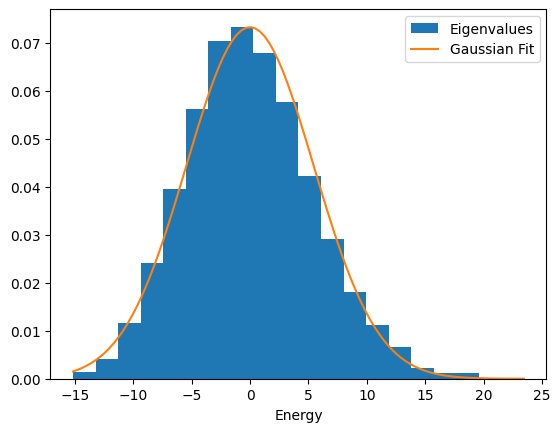

In [ ]:
plt.hist(evals, bins = 20, density = True, label = 'Eigenvalues');
mu = np.average(evals)
sigma = np.std(evals)
e_range = np.linspace(min(evals),max(evals),100)
gaussian = [(1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma)**2) for x in e_range]
plt.plot(e_range, gaussian, label = 'Gaussian Fit')
plt.xlabel('Energy')
plt.legend();

**1b**. We see that a Gaussian fits the density of states reasonably well. The mixed field Ising model (TFIM in a longitudinal field) is a Hamiltonian composed of a sum of local operators. The expectation for any Hamiltonian of this form is that its density of states will be Gaussian. There is no comprehensive proof of this but this is the expectation based on all the models that we know of.

One example in which this is very clear is that of $H = -\sum_i Z_i$. In this case, the Hamiltonian is just a sum of single site terms and the number of states at any given energy is just the number of states with $n_{\uparrow}$ spins pointing up. This number is merely $\begin{pmatrix} N \\ n_{\uparrow} \end{pmatrix}$. This choose function is maximized when $n_{\uparrow} = N/2$, which means 0 is the energy with the most states. Plotting this choose function as a function of $n_{\uparrow}$ will yield a Gaussian.


(Credit to Cheryne Jonay for this alternative explanation)

Another way to see this is using the relation

$$\rho(E)  \sim e^{S(E)} $$

where $S(E)$ is the entropy at energy $E$. As the entropy is maximal at infinite temperature (at E=0) and extensive, we obtain within the saddle point approximation,

$$\rho(E) \sim e^{S(0) + E^2 S''(0)} $$

As $S''(E)\big|_{E=0} = d\beta/dE \big|_{E=0}  = -1/(T^2 C_V)$ where $C_V$ is the specific heat at constant volume,

$$\rho(E) \sim e^{S(0) - E^2 /(T^2 C_V)  }$$

or

$$\rho(E) \sim \rho(0) e^{- \frac{E^2}{ T^2 C_V}  }$$

That is, the shape of the DOS near $E=0$ is Gaussian.

**1c.** For a local Hamiltonian, the bandwidth is expected to scale in the system size. A simple way to understand this is to think about how many new terms we have to add to the Hamiltonian as we increase the system size. In 1D, suppose we just had single site and nearest neighbor terms. Then, for each new site, we add 2 terms leading to linear scaling in $L$.

In $d$ dimensions, if each qubit participates in $m$ interactions, then the total terms in the Hamiltonian will be $mN/2$, where $N$ is the total number of qubits. The highest energy term would correspond to all of these terms being unsatisfied, and the lowest energy term would correspond to all of these terms being satisfied. This leads to an energy difference which is of order $N$.

**1d.** Right off the bat we ought to expect that that the standard deviation should scale subextensively. As we increase the size of the system, the number of states in the middle of the spectrum should grow far quicker than the number of states out in the tails.

The simple toy example of $\sum_i Z_i$ allows us to calculate this quantity. If we calculate the quantity in the microcanonical ensemble with equal weighting of all states (which is essentially an infinite temperature expectation value), then $\langle E \rangle = Tr(e^{-\beta H} H) / Tr(e^{-\beta H}) \to Tr(H) / 2^L = 0$. The expectation value of energy squared is $\langle E^2 \rangle = Tr(e^{\beta H} H^2) / Tr(e^{\beta H}) \to Tr(H^2)/2^L = 2^{-2} L$. From this we see that the variance grows linearly in $L$ and the standard deviation thus grows as $\sqrt{L}$.

(Credit to Cheryne Jonay for the following additional explanation.)

Going back to the saddle point approximation, the width of the $\log(\rho(E))=S(E)$ is set by the standard deviation of the Gaussian,  which is $\propto \sqrt{C_V}$. Since $C_V$ is extensive, this also gives $\sqrt{L}$.

Recall that the entropy is given by $S=\ln \Omega$, where $\Omega$ is the multiplicity of states consistent with a given set of thermodynamic parameters (such as energy, volume etc.), and we set $k_B = 1$. The density of states $N(E)$ is the number of eigenstates with energy $E$ per unit volume per unit energy and is a proxy for the entropy.

From the curve of entropy vs. energy, we can extract the temperature conjugate to each energy via $dS/dE = 1/T$. `Infinite temperature' corresponds to the energy density with the maximum entropy. Recall from your stat mech class that temperatures can be negative and positive (the slopes $dS/dE$ for your plot can be both positive and negative). A negative temperature $-T_0$ for $H$ simply corresponds to positive temperature $T_0$ for the Hamiltonian $-H$.

Indeed, we can find the equilibrium energy corresponding to a given temperature in the usual way using the Gibbs ensemble:
$\langle E\rangle_T =  \frac{1}{Z} \sum_\alpha e^{-E_\alpha/T}E_\alpha$, where the sum is over the complete basis of energy eigenstates $|E_\alpha\rangle$ and we have assumed there are no continuous symmetries other than energy.  

Finally, note that temperature is intensive and determined by the energy *density*, $E/V$. Recall that the uncertainty in the average energy at a given temperature in the canonical ensemble is $\Delta E \propto \sqrt{V}$. Thus, all states in a large window $\Delta E$ around $\langle E\rangle_T$ have the same temperature.  


e. What is the temperature corresponding to the ground state (i.e. the state at the bottom of the many-body spectrum?) [1pt]

f. What is the energy corresponding to infinite temperature? Where does this energy live in the many-body spectrum? [1pt]

g. What is the temperature corresponding to the highest excited state (i.e. the state at the top of the many-body spectrum?) [1pt]

h. Consider temperatures $T=0.1, 1, 10, 100, -100, -10, -1, -0.1$. Numerically compute the expectation value of the energy for each of these temperatures. Plot these as (labeled) vertical lines on the DOS plot. Also mark the infinite temperature energy computed in f. [4pts]

**1e.** In the thermodynamic limit, this is the temperature in the canonical ensemble which corresponds to a nonzero weight of the ground state and a zero weight for everything else. That will be when $\beta = ∞$ or when $T = 0$.

**1f.** As $\beta$ decreases, the states higher in energy grow in weight until $\beta = 0$, where every state becomes equally weighted. However, for large systems, because the number of states in the middle of the spectrum grows much faster than elsewhere, decreasing $\beta$ amounts to increasing the average energy towards the middle of the spectrum. Therefore, the energy corresponding to $\beta = 0$ or $T = \infty$ is the mid-spectrum energy.

**1g.** The temperature corresponding to the highest excited state would amount to making the weight of that state non-zero and making the weight of all other states 0. This is similar to the intuitition behind the ground state temperature. If the entire spectrum were inverted about $0$, this temperature would be $0$. In spirit, this effect can be realized by instead approaching $0$ temperature from the *negative side*. The temperature corresponding to the highest excited state is therefore $T \to 0^-$.

**1h.**

In [ ]:
Ts = [0.1,1,10,100,-100,-10,-1,-0.1]
L = 12
H_mat = MFIM(L, J, hz, hx)
evals = np.linalg.eigvalsh(H_mat.todense())

In [ ]:
energy_expectations = []
for T in Ts:
  Z = sum(np.exp(-(1 / T) * evals)) # Since we already have the eigenvalues, we can take the trace in the diagonal basis.
  energy_expectations.append(sum(evals * np.exp(-(1 / T) * evals)) / Z)


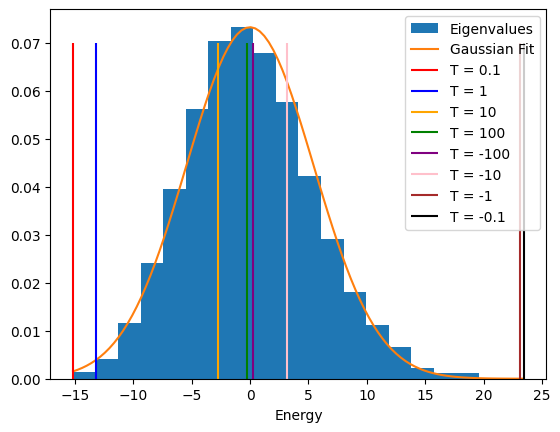

In [ ]:
plt.hist(evals, bins = 20, density = True, label = 'Eigenvalues');
mu = np.average(evals)
sigma = np.std(evals)
e_range = np.linspace(min(evals),max(evals),100)
gaussian = [(1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma)**2) for x in e_range]
plt.plot(e_range, gaussian, label = 'Gaussian Fit')
plt.xlabel('Energy')

colors = ['red', 'blue', 'orange', 'green', 'purple', 'pink', 'brown', 'black']
for i in range(len(Ts)):
  plt.vlines(energy_expectations[i], 0, 0.07, color = colors[i], label = f'T = {Ts[i]}')

plt.legend();

# Question 2: Diagonal ETH (15 pts)#



We will now verify the (diagonal) ETH for the non-integrable transverse field Ising chain, for a particular local observable $A= \sigma_{L/2}^x$. The statement of diagonal ETH is:

$A_{\alpha \alpha}   = \langle A\rangle_T + O(1/L) +O(e^{-S/2})$ (Equation 1)

where $|\alpha\rangle$ is a many-body eigenstate with eigenenergy $E$, and  $\langle A\rangle_T = \frac{1}{Z}\mbox{Tr } A e^{-H/T}$ is the thermal expectation value of $A$ at a temperature $T$ corresponding to the energy $E$, and $S(E) \propto L$ is the entropy, so that $e^{S(E)}$ is the relevant Hilbert space dimension at energy $E$.

Conditions to verify:
1. The diagonal eigenstate expectation value (EEV) $A_{\alpha\alpha}$ varies smoothly as a function of the energy of the eigenstates.
2. The eigenstate-to-eigenstate fluctuations in the EEVs decrease (exponentially) with increasing system size. Note that this is closely related to point 1. The energy difference between neighboring eigenstates in the middle of the many-body spectrum is exponentially small in $L$. Thus, if $O(E)$ is a smooth function of $E$, we expect differences between nearby eigenstate expectation values to be exponentially close. This is the $O(e^{-S/2})$ part in Equation (1) above. Note that all states within some $O(1)$ energy window $\Delta E$ have the same energy density and hence the same temperature, so $\langle A\rangle_T$ is the same for all states in the window.

2. The eigenstate expectation value of the observable agrees with the expected thermodynamic answer, $\langle A\rangle_T$ at the same temperature. However, note that the difference between the EEV and $\langle A\rangle_T$ only decreases polynomially with $1/L$ (similar in spirit to the agreement between canonical and microcanonical ensembles in standard stat mech, up to poly(1/L) corrections).

Useful references:
1. Srednicki, The approach to thermal equilibrium in quantized chaotic systems; https://arxiv.org/abs/cond-mat/9809360v2

2. Buegeling, Moessner, Haque, Finite-size scaling of eigenstate thermalization; https://arxiv.org/abs/1308.2862

a. Make scatter plots of $A_{\alpha \alpha}$ vs. $E_\alpha$ for $L=8,10,12$. Do you visually see the distributions narrowing with increasing $L$? You may find the hist2d function in matplotlib useful. (5pts)

b. Pick an array of logarithmically spaced temperatures between 0.1 and $10^{10}$ (check out np.logspace). For each temperature in your list, compute $\langle A\rangle_T$ and  $\langle H\rangle_T$. Plot $\langle A\rangle_T$ vs.  $\langle H\rangle_T$ on the scatter plot in (a) for the largest system size. Does the thermal curve track the scatter plot? (5pts)

c. Set $h_z=0$ and repeat a-c. When $h_z=0$, the model is the TFIM which is an integrable non-interacting model after performing a Jordan-Wigner transformation. Thus, we do not expect ETH to hold for this model, and expect fluctuations to be be much larger. Do you see this?  (5pts)

**2a.**

In [ ]:
def plot_A_expectation(L, J, hz, hx):
  H_mat = MFIM(L, J, hz, hx)
  s0_list, sx_list,sy_list,sz_list = gen_s0sxsysz(L)
  A = sx_list[L//2]
  evals, evecs = np.linalg.eigh(H_mat.todense())
  expectation_values = np.array(np.conj(evecs.T) @ A.dot(evecs), dtype = 'float')
  plt.scatter(evals, np.diag(expectation_values), label = f'L = {L}')
  plt.xlabel('$E_\\alpha $')
  plt.ylabel('$A_{\\alpha \\alpha }$')
  plt.legend();



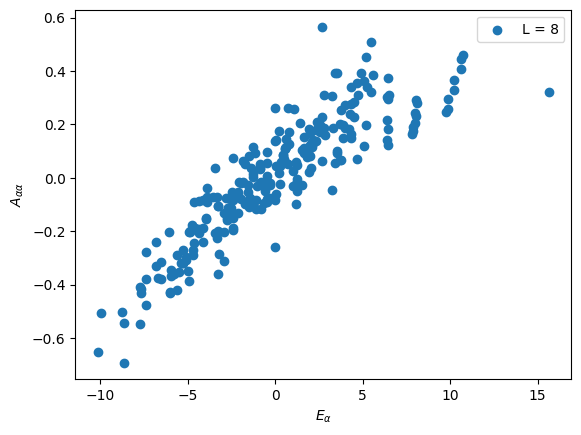

In [ ]:
plot_A_expectation(8, J, hz, hx)

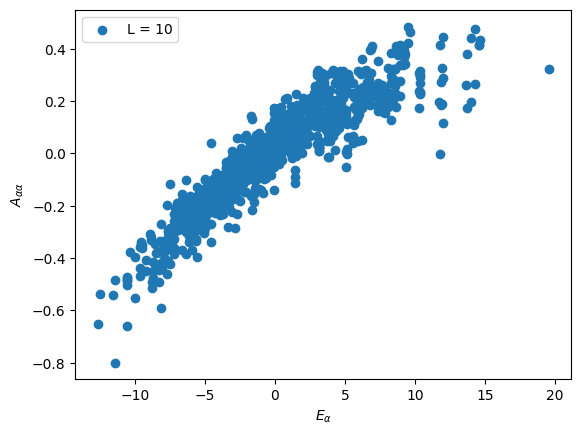

In [ ]:
plot_A_expectation(10, J, hz, hx)

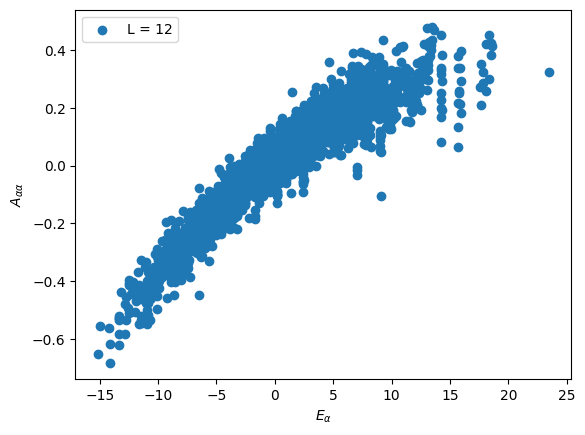

In [ ]:
plot_A_expectation(12, J, hz, hx)

There is a bandwidth of fluctuations but we can clearly see a strong correlation between energy and the expectation value of the observable.

**2b.**

In [ ]:
L = 12
Ts = np.logspace(-1,10,20)

H_mat = MFIM(L, J, hz, hx)
s0_list, sx_list,sy_list,sz_list = gen_s0sxsysz(L)
A = sx_list[L//2]
evals, evecs = np.linalg.eigh(H_mat.todense())

# Rotate A into the energy eigenbasis
A_r = np.array(np.conj(evecs.T) @ A.dot(evecs), dtype = 'float')

energy_expectations = []
observable_expectations = []

# We can also calculate the negative temperatures (optional)
energy_expectations_neg = []
observable_expectations_neg = []

for T in Ts:
  Z = np.trace(np.diag(np.exp(-(1/T) * evals)))
  observable_expectations.append(np.trace(np.diag(np.exp(-(1/T) * evals)) @ A_r) / Z)
  energy_expectations.append( sum(np.exp(-(1/T) * evals) * evals) / Z)

  Z = np.trace(np.diag(np.exp((1/T) * evals)))
  observable_expectations_neg.append(np.trace(np.diag(np.exp((1/T) * evals)) @ A_r) / Z)
  energy_expectations_neg.append( sum(np.exp((1/T) * evals) * evals) / Z)


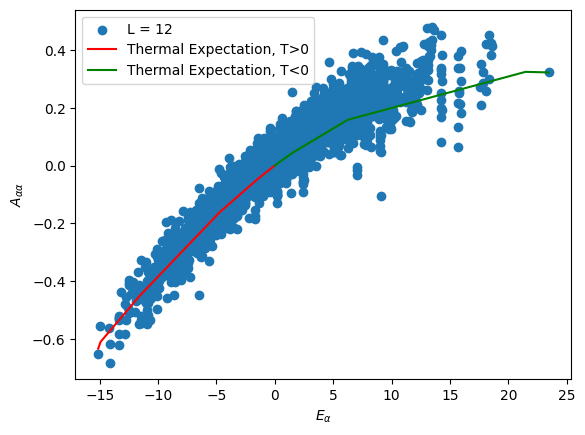

In [ ]:
plot_A_expectation(12, J, hz, hx)
plt.plot(energy_expectations, observable_expectations, color = 'red', label = 'Thermal Expectation, T>0')
plt.plot(energy_expectations_neg, observable_expectations_neg, color = 'green', label = 'Thermal Expectation, T<0')
plt.legend();

**2c.**

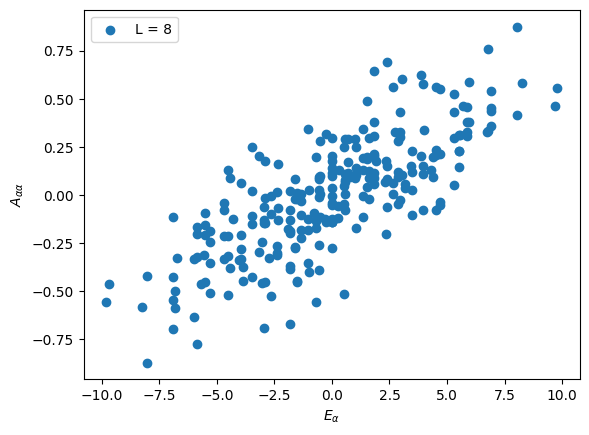

In [ ]:
plot_A_expectation(8, J, 0, hx)

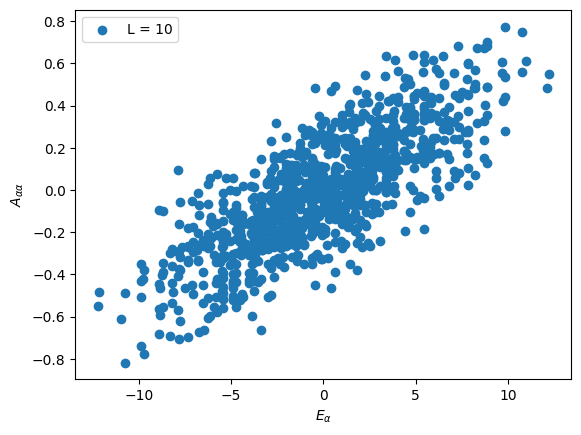

In [ ]:
plot_A_expectation(10, J, 0, hx)


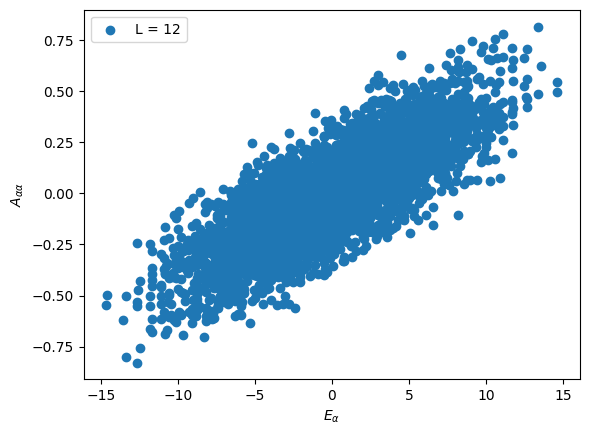

In [ ]:
plot_A_expectation(12, J, 0, hx)

We can see that the fluctations in an energy window are not narrowing. We can bin the energies to see the fluctuations more clearly.

In [ ]:
def plot_A_fluctuations(L, J, hz, hx, bins):
  H_mat = MFIM(L, J, hz, hx)
  s0_list, sx_list,sy_list,sz_list = gen_s0sxsysz(L)
  A = sx_list[L//2]
  evals, evecs = np.linalg.eigh(H_mat.todense())
  expectation_values = np.array(np.conj(evecs.T) @ A.dot(evecs), dtype = 'float')
  energy_bins = np.linspace(min(evals), max(evals), bins)

  fluctuations = []
  start = 0
  for i in range(1, len(energy_bins)):
    idx = np.where(evals < energy_bins[i])[0]
    A_trunc = expectation_values[start:idx[-1], start:idx[-1]]
    start = idx[-1]
    fluctuations.append(np.std(np.diag(A_trunc)))

  plt.scatter(energy_bins[:-1], fluctuations, label = f'L = {L}')
  plt.xlabel('$E_\\alpha $')
  plt.ylabel('$\\sigma_A$')
  plt.legend();



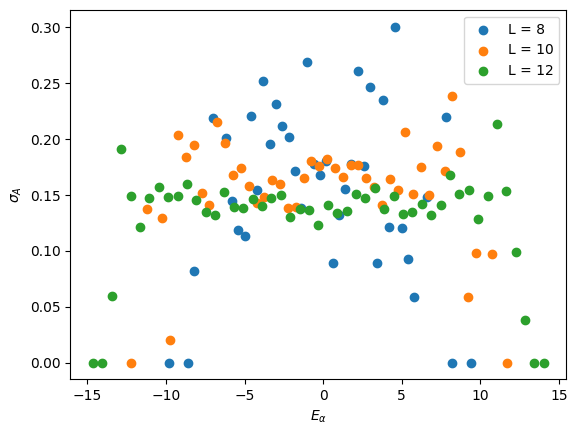

In [ ]:
plot_A_fluctuations(8, J, 0, hx, 50)
plot_A_fluctuations(10, J, 0, hx, 50)
plot_A_fluctuations(12, J, 0, hx, 50)

The standard deviation at all energy windows is not going down with system size. It is staying roughly constant at ~0.15.

# Question 3: Quenches (25 pts)#

Next, we will consider dynamics starting from general initial states $|\psi_0\rangle$. Thermalization means $\langle \psi(t)|A|\psi(t)\rangle \rightarrow  \langle A\rangle_T$ at late times, where the temperature is set by the energy density of the initial state. The instantaneous fluctuations in time are again supposed to be exponentially small in $L$, scaling as $e^{-S/2}$.  

a. Fix L=10. Pick initial product states $|\psi_0\rangle $ with different expectation values of energies spanning the spectrum. It is easiest to choose product states in the $Z$ basis, which are of the form $|\uparrow \downarrow \cdots \uparrow\rangle$.  Note that the diagonal entries of $H$ are equal to $\langle n|H|n\rangle$ for product states $|n\rangle$ in the $Z$ basis. By sorting the diagonal entries, pick 10 indices $n$ corresponding to (roughly) equally spaced energy expectation values. Indicate these energies as vertical lines on the DOS. (5pts)

b. Obtain $\langle A\rangle_T$ for each of the initial states you picked in a. Note that it is easiest to do this approximately by picking a finely spaced list of temperatures, and obtaining $\langle A\rangle_T$ and  $\langle H\rangle_T$  for this list, as in Question 2. These parametric plot of $\langle A\rangle_T$ vs  $\langle H\rangle_T$ should look smooth. You can then read off the (interpolated) expected thermal $\langle A\rangle_T$s corresponding to the energies of the different initial states in (a). (5pts)

c. Plot $\langle \psi(t)|A|\psi(t)\rangle$ vs. $t$ for each of the initial states in (a) on the same plot using different colors. Add dashed lines indicating the expected thermal values. Do the late-time expectation values agree with the thermal values? (5pts)

d. Fix a particular initial state corresponding to infinite temperature, and plot $\langle \psi(t)|A|\psi(t)\rangle$ vs. $t$ for $L=8,10,12$ on the same plot. Do you see the late time fluctuations narrowing with increasing $L$? Verify that the late-time fluctuations scale as $e^{-S/2}\sim 2^{-L/2}$. (You may find it convenient to start with a $+Y$ product state which is at infinite temperature and can allow you to easily compare across sizes; the gen_state_bloch function will help you obtain such a state). (5pts)

e. No numerics for this part. Expand $\langle \psi(t)|A|\psi(t)\rangle$  in the eigenbasis of the Hamiltonian, separating the sums between time-independent diagonal contributions and the time-dependent off-diagonal ones. Use the ETH ansantz for off-diagonal matrix elements, and assume that your eigenvectors look like random vectors (this is a reasonable approximation for infinite temperature eigenstates which dominate the DOS). By considering the scaling of all the different compnents, show that the instantaneous off-diagonal fluctuation scales as $e^{-S/2}$ for this late time. (5pts)





**3a.**

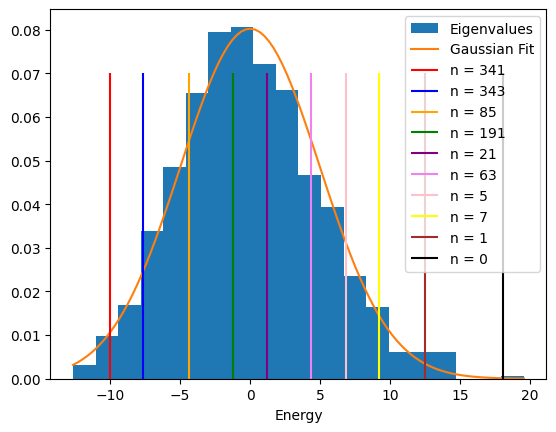

In [6]:
L = 10
H_mat = MFIM(L, J, hz, hx)
evals, evecs = np.linalg.eigh(H_mat.todense())

# Get the diagonal of the Hamiltonian
H_diag = np.diag(H_mat.todense())

# Bin the energies so we can eventually sort the diagonal elements
energy_bins = np.linspace(min(H_diag), max(H_diag), 11)
indices = []
product_state_energies = []

# We will find the indices n such that <n|H|n> lies in a particular bin.
for b in range(len(energy_bins)):
  V = abs(H_diag - energy_bins[b])
  i = np.where(V == min(V))[0][0]
  indices.append(i)
  product_state_energies.append(H_diag[i])


plt.hist(evals, bins = 20, density = True, label = 'Eigenvalues');
mu = np.average(evals)
sigma = np.std(evals)
e_range = np.linspace(min(evals),max(evals),100)
gaussian = [(1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma)**2) for x in e_range]
plt.plot(e_range, gaussian, label = 'Gaussian Fit')
plt.xlabel('Energy')

colors = ['red', 'blue', 'orange', 'green', 'purple', 'violet', 'pink', 'yellow', 'brown', 'black']
for i in range(10):
  plt.vlines(product_state_energies[i], 0, 0.07, color = colors[i], label = f'n = {indices[i]}')

plt.legend();



**3b.**

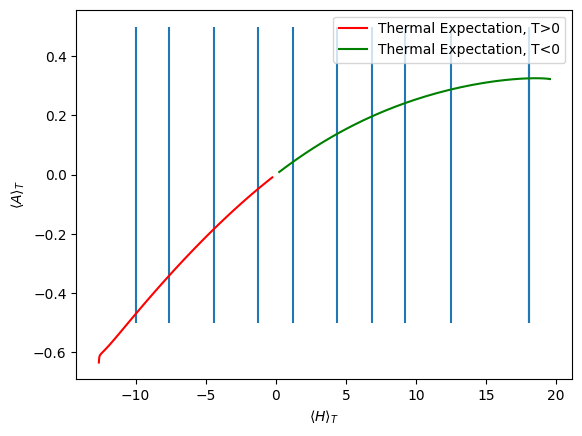

In [7]:
L = 10
Ts = np.logspace(-1,2,100)

s0_list, sx_list,sy_list,sz_list = gen_s0sxsysz(L)
A = sx_list[L//2]

# Rotate A into the energy eigenbasis
A_r = np.array(np.conj(evecs.T) @ A.dot(evecs), dtype = 'float')

energy_expectations = []
observable_expectations = []

energy_expectations_neg = []
observable_expectations_neg = []

for T in Ts:
  Z = np.trace(np.diag(np.exp(-(1/T) * evals)))
  observable_expectations.append(np.trace(np.diag(np.exp(-(1/T) * evals)) @ A_r) / Z)
  energy_expectations.append( sum(np.exp(-(1/T) * evals) * evals) / Z)

  Z = np.trace(np.diag(np.exp((1/T) * evals)))
  observable_expectations_neg.append(np.trace(np.diag(np.exp((1/T) * evals)) @ A_r) / Z)
  energy_expectations_neg.append( sum(np.exp((1/T) * evals) * evals) / Z)



for i in range(len(product_state_energies)):
  plt.vlines(product_state_energies[i], -.5, .5)


plt.plot(energy_expectations, observable_expectations, color = 'red', label = 'Thermal Expectation, T>0')
plt.plot(energy_expectations_neg, observable_expectations_neg, color = 'green', label = 'Thermal Expectation, T<0')
plt.xlabel('$\\langle H \\rangle_T $')
plt.ylabel('$\\langle A \\rangle_T$')
plt.legend();

The y coordinate of the intersection of the vertical lines with the red and green curves yields the thermal expectation value of the observable for the product states. We can interpolate to find the temperatures which yield energy expectation values close to that of the product state.

In [8]:
interpolated_temperatures = []
interpolated_temperatures_neg = []
energy_expectations = np.array(energy_expectations)
energy_expectations_neg = np.array(energy_expectations_neg)
interpolated_indices = []

# We have a list of energy expectation values at different temperatures. We can subtract off each of the product state energies, and find the index where the value is closest to 0.
# The temperature at this index is the desired interpolated temperature. 4 of the lines intersect the positive temperature curve while the rest intersect the negative temperature one.
for i in range(4):
  V = abs(energy_expectations - product_state_energies[i])
  j = np.where(V == min(V))[0][0]
  interpolated_temperatures.append(Ts[j])
  interpolated_indices.append(j)

for i in range(4,11):
  V = abs(energy_expectations_neg - product_state_energies[i])
  j = np.where(V == min(V))[0][0]
  interpolated_temperatures.append(-Ts[j])
  interpolated_indices.append(j)


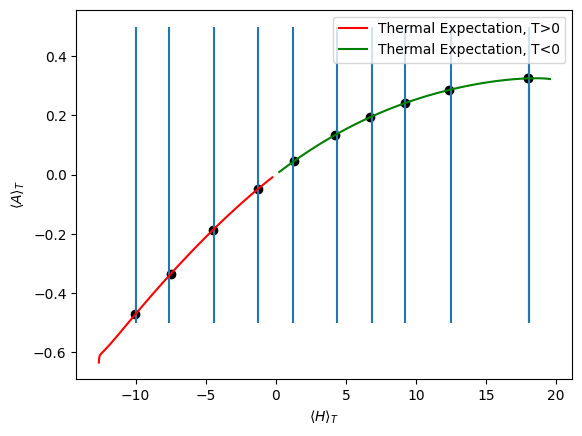

In [9]:
# We can check that our interpolated temperatures yield expectation values close to the intersections.

for i in range(len(product_state_energies)):
  plt.vlines(product_state_energies[i], -.5, .5)


for T in interpolated_temperatures:
  Z = np.trace(np.diag(np.exp(-(1/T) * evals)))
  Aval = np.trace(np.diag(np.exp(-(1/T) * evals)) @ A_r) / Z
  Eval = sum(np.exp(-(1/T) * evals) * evals) / Z
  plt.scatter([Eval], [Aval], color = 'k')


plt.plot(energy_expectations, observable_expectations, color = 'red', label = 'Thermal Expectation, T>0')
plt.plot(energy_expectations_neg, observable_expectations_neg, color = 'green', label = 'Thermal Expectation, T<0')
plt.xlabel('$\\langle H \\rangle_T $')
plt.ylabel('$\\langle A \\rangle_T$')
plt.legend();

**3c.**

We will perform time evolution in the energy basis. This avoids having to exponentiate a matrix. We have to rotate all the Z basis objects into the energy basis, but then we can just exponentiate the list of eigenvalues. The time evolution operator is then just a diagonal matrix.

In [10]:
L = 10
psi = np.zeros((2**L, 11))
for i in range(len(indices)):
  psi[indices[i], i] = 1

# Rotate psi into the energy basis
psi_r = np.conj(evecs.T) @ psi

ts = np.logspace(-2,3,1000)

quench = []
for t in ts:

  Udiag = np.diag(np.exp(-1j * evals * t))

  psi_t = Udiag @ psi_r

  exp_values = np.diag(np.conj(psi_t.T) @ A_r.dot(psi_t))

  quench.append(exp_values)

quench = np.array(quench)


Text(0, 0.5, '$\\langle \\psi(t) | A | \\psi(t) \\rangle$')

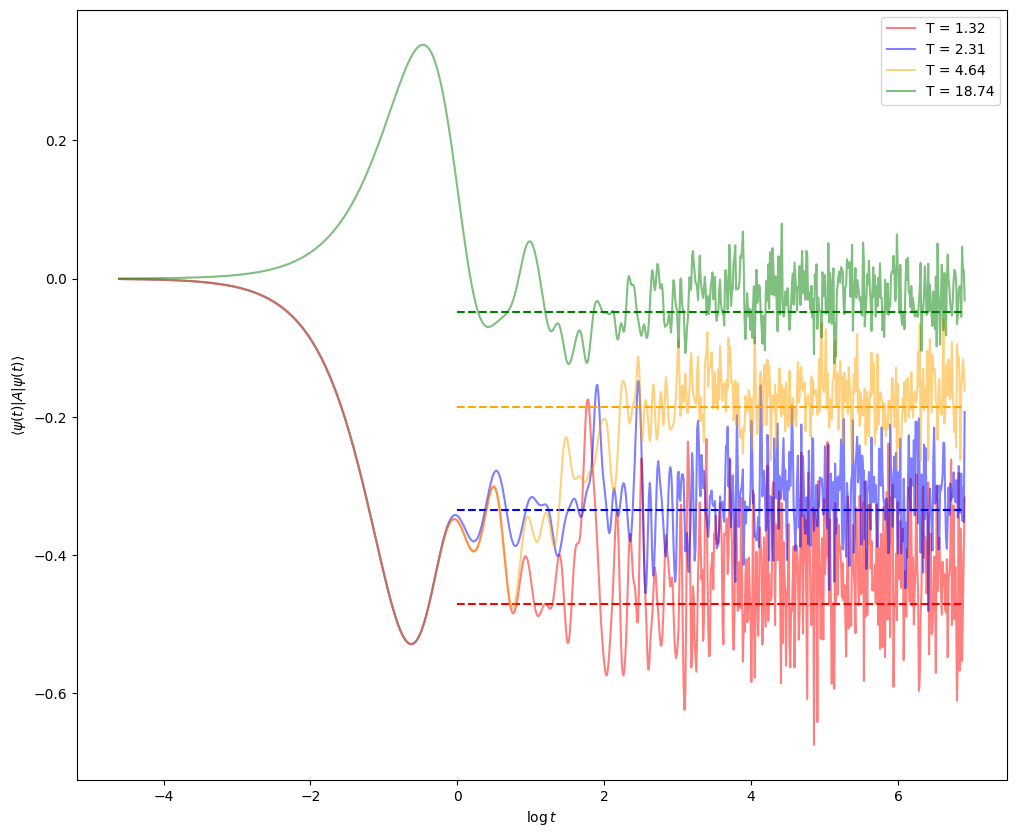

In [11]:
plt.figure(figsize = (12,10))
colors = ['red', 'blue', 'orange', 'green', 'purple']
for i in range(4):
  plt.plot(np.log(ts), quench.T[i], color = colors[i], label = f'T = {round(interpolated_temperatures[i], 2)}', alpha=0.5)
  plt.hlines(observable_expectations[interpolated_indices[i]], 0, max(np.log(ts)), color = colors[i], linestyles = 'dashed')

plt.legend();
plt.xlabel('$\log t$')
plt.ylabel('$\\langle \psi(t) | A | \psi(t) \\rangle$')


Text(0, 0.5, '$\\langle \\psi(t) | A | \\psi(t) \\rangle$')

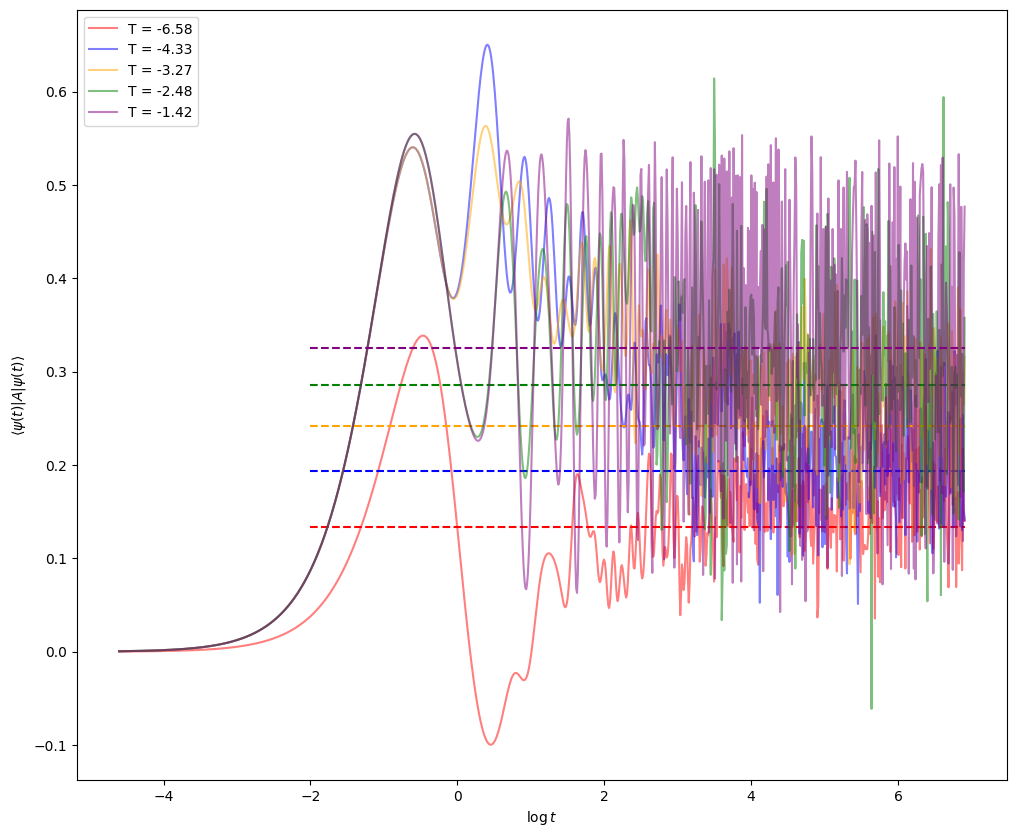

In [12]:
plt.figure(figsize = (12,10))
colors = ['red', 'blue', 'orange', 'green', 'purple', 'black']
for i in range(5,10):
  plt.plot(np.log(ts), quench.T[i], color = colors[i-5], label = f'T = {round(interpolated_temperatures[i], 2)}', alpha=0.5)
  plt.hlines(observable_expectations_neg[interpolated_indices[i]], -2, max(np.log(ts)), color = colors[i-5], linestyles = 'dashed')

plt.legend();
plt.xlabel('$\log t$')
plt.ylabel('$\\langle \psi(t) | A | \psi(t) \\rangle$')



**3d.** We will use Y product states here.

In [13]:
def allYup_state(L):
  up = np.array([1j, 1])
  state = np.copy(up)
  for i in range(1, L):
    state = np.kron(state, up)
  state = state / np.linalg.norm(state)
  return state

In [14]:
Ls = [8,10,12]
quenchL = {}

def get_Ystate_quench(L):
  H_mat = MFIM(L, J, hz, hx)
  evals, evecs = np.linalg.eigh(H_mat.todense())
  s0_list, sx_list,sy_list,sz_list = gen_s0sxsysz(L)
  A = sx_list[L//2]

  # Rotate A into the energy eigenbasis
  A_r = np.array(np.conj(evecs.T) @ A.dot(evecs), dtype = 'float')
  psi = allYup_state(L)

  # Rotate psi into the energy basis
  psi_r = np.conj(evecs.T) @ psi

  ts = np.logspace(-2,3,1000)
  quench = []
  for t in ts:
    Udiag = np.diag(np.exp(-1j * evals * t))
    psi_t = Udiag @ psi_r.T
    exp_values = np.diag(np.conj(psi_t.T) @ A_r.dot(psi_t))
    quench.append(exp_values)

  quench = np.array(quench)
  return quench

for L in Ls:
  quenchL[L] = get_Ystate_quench(L)




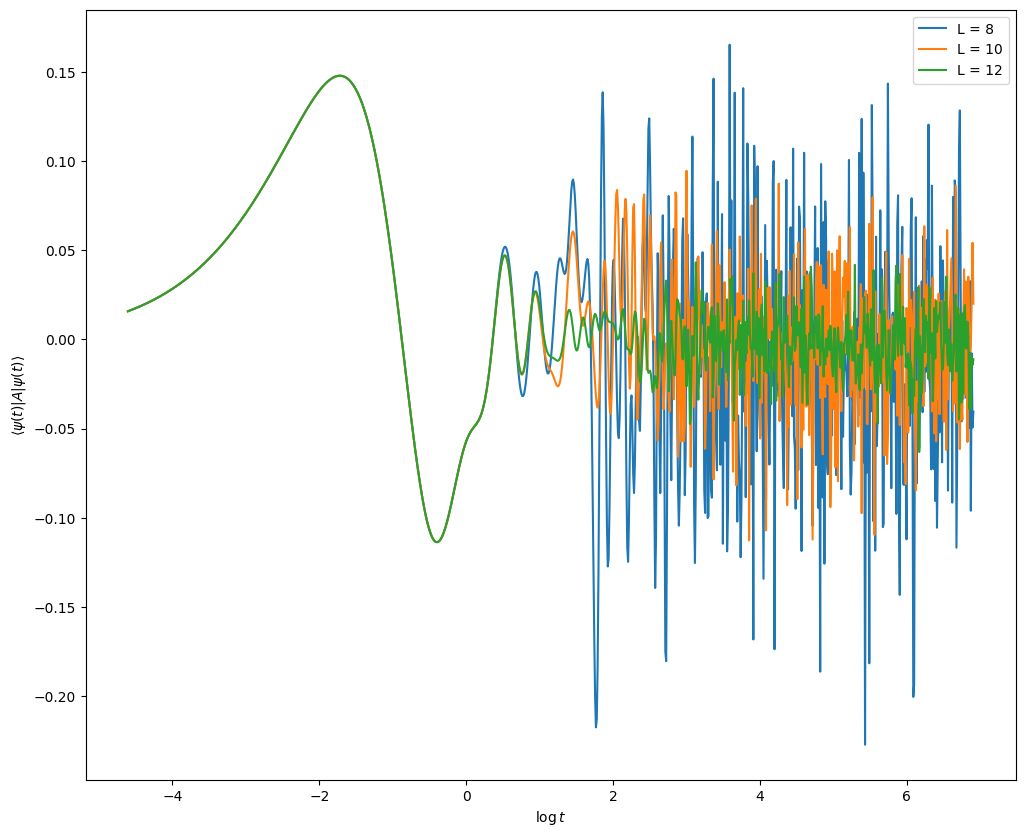

In [15]:
plt.figure(figsize = (12,10))
ts = np.logspace(-2,3,1000)
for L in Ls:
  plt.plot(np.log(ts), quenchL[L], label = f'L = {L}')

plt.xlabel('$\log t$')
plt.ylabel('$\\langle \psi(t) | A | \psi(t) \\rangle$')
plt.legend();

Text(0, 0.5, '$\\log_2 \\sigma_{t \\to \\infty}$')

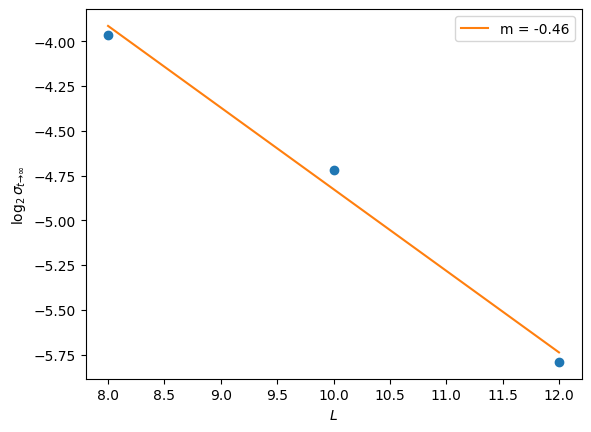

In [34]:
fluctuations = [np.std(quenchL[L][-200:]) for L in Ls]
plt.plot(Ls, np.log2(fluctuations), 'o')
m,b = np.polyfit(Ls, np.log2(fluctuations), deg = 1)
plt.plot(Ls, [m * L + b for L in Ls], label = f'm = {round(m,2)}')
plt.legend();
plt.xlabel('$L$')
plt.ylabel('$\log_2 \\sigma_{t \\to \infty}$')


We calculated the standard deviation over the last 200 time steps. In some sense this is arbitrary but we should make sure to only average over time steps where the system has thermalized. A linear fit to the base 2 logarithm of the standard deviations against system size yields a slope which is approximately $-1/2$, which agrees with the prediction.

**3e.**

$\langle \psi(t) | A | \psi(t) \rangle = \langle \psi(0) | e^{-i H t} A e^{i H t} | \psi(0) \rangle$ \\
$=\left(\sum_n c^*_n \langle n| \right) | e^{-i H t} A e^{i H t} | \left(\sum_n c_n | n \rangle \right)$ \\
$ = \left(\sum_n c^*_n e^{-iE_n t} \langle n| \right) A |\left(\sum_n e^{iE_n t}c_n | n \rangle \right)$ \\
$=\sum_n|c_n|^2A_{nn} + \sum_{nm} c^*_n c_m e^{i(E_m - E_n) t}A_{nm}$

Take our Hilbert space dimension to be $\mathcal{D}$. There are $\mathcal{D}^2$ terms in $\sum_{nm} c^*_n c_m e^{i(E_m - E_n) t}A_{nm}$. The $c_n$s are random numbers since the eigenstates are random vectors. With the Hilbert space dimension normalization though, the $c_n$s scale as $\frac{1}{\sqrt{\mathcal{D}}}$. We can replace the $c_n$s with their typical value $1/\sqrt{\mathcal{D}}$ and pull them out of the sum. \\
$\sum_{nm} c^*_n c_m e^{i(E_m - E_n) t}A_{nm} \sim \frac{1}{\mathcal{D}} \sum_{nm} e^{i(E_m - E_n) t}A_{nm} $. Now, the eigenvectors are random vectors and because $A$ is a local operator, $A |m\rangle$ should also be a random vector with typical elements that go as $\frac{1}{\sqrt{\mathcal{D}}}$ When we take the inner product with another random vector $\langle n|$, we get a sum over random elements. This goes like some random walk with $\mathcal{D}$ steps over typical elements $1/{\sqrt{\mathcal{D}}} \times 1/{\sqrt{\mathcal{D}}}$ which amounts to $1/{\mathcal{D}} \cdot \sqrt{\mathcal{D}}$. \\

Now we are left with $\sim \frac{1}{\mathcal{D}^{3/2}} \sum_{nm} e^{i(E_m - E_n) t} $. We can replace the sum over random phases with a root mean square. $\sum_{nm} e^{i(E_m - E_n) t}  \sim \sqrt{\left(\sum_{nm} e^{i(E_m - E_n) t}\right)\left(\sum_{n'm'} e^{i(E_m' - E_n') t}\right)} = \sqrt{\mathcal{D}^2 + \langle \sum_i e^{i\phi_i t} \rangle } \sim \mathcal{D}$. The $\phi_i$ are random phases. We are left with \\
$\sum_{nm} c^*_n c_m e^{i(E_m - E_n) t}A_{nm} \sim \frac{1}{\mathcal{D}^{3/2}} \mathcal{D} = \mathcal{D}^{-1/2} = 2^{-L/2}$. This reproduces the desired scaling relationship as $e^{-S/2}\sim 2^{-L/2}$ .